In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
plt.style.use(['science', 'notebook'])

# Question 1

The TCP is given by

$$TCP = e^{-N_s}$$

where 

$$ N_s = \sum_i \rho_{ijk}v_{ijk} S(D_{ijk},d_{ijk},\alpha,\alpha/\beta)$$

Now we can identify:

* $\rho_{ijk}v_{ijk} \to N_0 p_i$ where $N_0$ is the total initial cell population and $p_i$ is the proportion of cells in a subpopulation $i$
* $S(D_{ijk},d_{ijk},\alpha,\alpha/\beta) \to S_i = e^{-\alpha_i D - \beta_i d D}$. This is the survival rate for a subpopulation of cells with a particular poisson decay scheme $(\alpha_i, \beta_i)$ ignoring repopulation.

It follows that

$$N_s = \sum_i N_0 p_i e^{-\alpha_i D - \beta_i d D}$$

First we define initial cells, proportion of subpopulations, dose per fraction, and $\alpha$ and $\beta$ values for each subpopulation:

In [2]:
N0 = 4e6
p1 = np.array([1/3,1/3,1/3])
p2 = np.array([1/3,0.167,0.5])
p3 = np.array([0.5,0.25,0.25])
d = 2
D = np.linspace(0,70,100)
alpha = np.array([0.18, 0.2, 0.22])
beta = alpha/10

Obtain the tumour control probabilities for the different configurations

In [3]:
def TCP(D, d, ps, alphas, betas):
    return np.exp(-sum([N0*p*np.exp(-a*D-b*d*D) for p,a,b in zip(ps,alphas,betas)]))
TCPs = [TCP(D,d,p,alpha,beta) for p in [p1,p2,p3]]   

And plot:

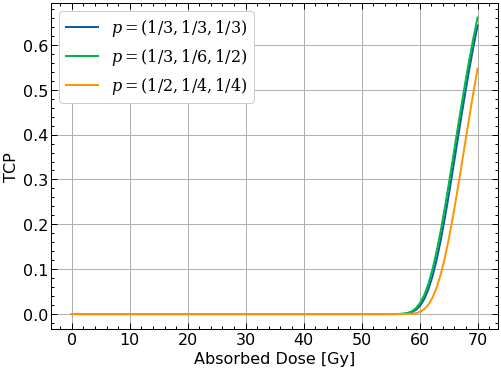

In [4]:
plt.plot(D, TCPs[0], label=r'$p=(1/3,1/3,1/3)$')
plt.plot(D, TCPs[1], label=r'$p=(1/3,1/6,1/2)$')
plt.plot(D, TCPs[2], label=r'$p=(1/2,1/4,1/4)$')
plt.legend(facecolor='white', framealpha=1, frameon=True)
plt.xlabel('Absorbed Dose [Gy]')
plt.ylabel('TCP')
plt.grid()

From this plot it is clear that the subpopulation mostly responsible for the outcome is the subpopulation with the lowest $\alpha$ value. This is because

* The shape of the curve changes little when proportions $p_2$ and $p_3$ are adjusted, which have higher values of $\alpha$.
* The shape of the curve changes when the proportion of cells $p_1$ with the lowest corresponding value of $\alpha$ change. This is represented by the orange curve.

In general, the tumour control probability decreases when the proportion of cells with the lowest value of $\alpha$ is increased. Note that these cells require more dose for more decay (slower exponential decay), so this result is intuitive.

# Question 2

Put the data into numpy arrays

In [5]:
p = np.array([0.2,0.2,0.15,0.1,0.35,0])
D = np.array([7000,6900,6500,5500,3800,0])
p_cumulative = np.flip(p.cumsum())
D_cumulative = np.flip(D)

Produce the plot

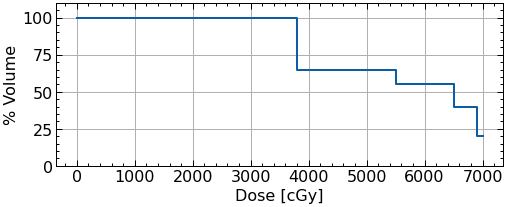

In [6]:
plt.figure(figsize=(8,3))
plt.step(D_cumulative,p_cumulative*100)
plt.grid()
plt.ylabel('% Volume')
plt.xlabel('Dose [cGy]')
plt.ylim(0,110)
plt.show()

Compute the efective volume (and dose can be computed using

$$V_{eff} = \sum_i v_i \left(\frac{D_i}{D_{max}}\right)^{1/n}$$
$$D_{eff} = \left(\sum_i v_i D_i^{1/n}\right)^n$$

where $n=0.12$ for the rectum.

In [7]:
Veff = np.sum(p*(D/D.max())**(1/0.12))
Deff = np.sum(p*D**(1/0.12))**0.12
print(f'The reduced DVH corresponds to Veff={Veff*100:.2f}% and Deff={Deff:.2f}Gy')

The reduced DVH corresponds to Veff=47.38% and Deff=6399.92Gy


Show the reduced DVH next to the DVH on a plot:

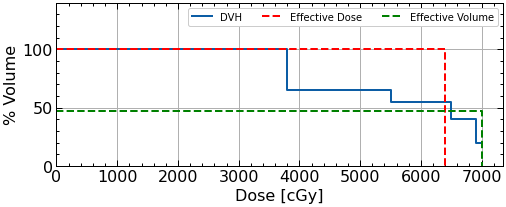

In [8]:
plt.figure(figsize=(8,3))
plt.step(D_cumulative,p_cumulative*100, label='DVH')
plt.step([0,Deff,Deff], [100,100,-100], color='r', ls='--', label='Effective Dose')
plt.step([0,D.max(),D.max()], [100*Veff,100*Veff,-100], color='g', ls='--', label='Effective Volume')
plt.grid()
plt.ylabel('% Volume')
plt.xlabel('Dose [cGy]')
plt.ylim(0,140)
plt.xlim(left=0)
plt.legend(facecolor='white', framealpha=1, frameon=True, fontsize=10, ncol=3)
plt.show()

# Question 3

The total surviving fraction of cells after $i$ procedures given in immediate succession (no repopulation in between) is given by
 
$$SF_{tot} = \prod_{i} SF_i $$

The BED for each surviving fraction $i$ is given by $e^{-\alpha BED_i} = SF_i$. This implies that

$$SF_{tot} = \prod_i e^{-\alpha BED_i} = e^{-\alpha \sum_i BED_i}$$

The total BED is given by

$$SF_{tot} = e^{-\alpha BED}$$

Equating these last two equations:

$$e^{-\alpha BED} = e^{-\alpha \sum_i BED}$$

and equating the terms in the exponentials:

$$BED = \sum_i BED_i$$

# Question 4

For fractionated exposure without accounting for proliferation

$$BED = D(1+d/(\alpha/\beta))$$

implying that

$$\frac{1}{D} = \frac{1}{BED} + \frac{1}{BED (\alpha/\beta)}d$$

Referring to $y=mx+b$, we can identify

* $1/D$ as $y$ 
* $d$ as $x$
* $\frac{1}{BED}$ as $b$ (intercept)
* $\frac{1}{BED (\alpha/\beta)}$ as $m$ (slope)

So it follows that $\alpha/\beta = b/m$ when fitting a best fit line to $1/D$ and $d$ data

In [9]:
d = np.array([2, 2.5, 2.9])
D = np.array([70, 2.5*25, 2.9*20])

Get function for line, and use `curve_fit` to obtain optimal values for $m$ and $b$.

In [10]:
def line(x, m, b):
    return m*x+b
(m,b), pcov = curve_fit(line, d, 1/D)
ratio = b/m

Print obtained value through best fit:

In [11]:
print(f'The value of alpha/beta is {ratio:.2f}Gy')

The value of alpha/beta is 2.35Gy
